# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
DATA_DIR = Path("datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset")

X_train = np.loadtxt(DATA_DIR / "train" / "X_train.txt")
y_train = np.loadtxt(DATA_DIR / "train" / "y_train.txt").astype(int)

X_test = np.loadtxt(DATA_DIR / "test" / "X_test.txt")
y_test = np.loadtxt(DATA_DIR / "test" / "y_test.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [5]:
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

Вопрос 1 (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

Варианты:
- 56
- 65
- 66
- 193

Ответ: 65

In [10]:
pca.n_components_

np.int64(65)

Вопрос 2 (0.5 балла)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

Варианты:
- 45
- 51
- 56
- 61

Ответ: 51

In [11]:
pca.explained_variance_ratio_[0] * 100

np.float64(50.73822103501329)

Визуализируйте данные в проекции на первые две главные компоненты.

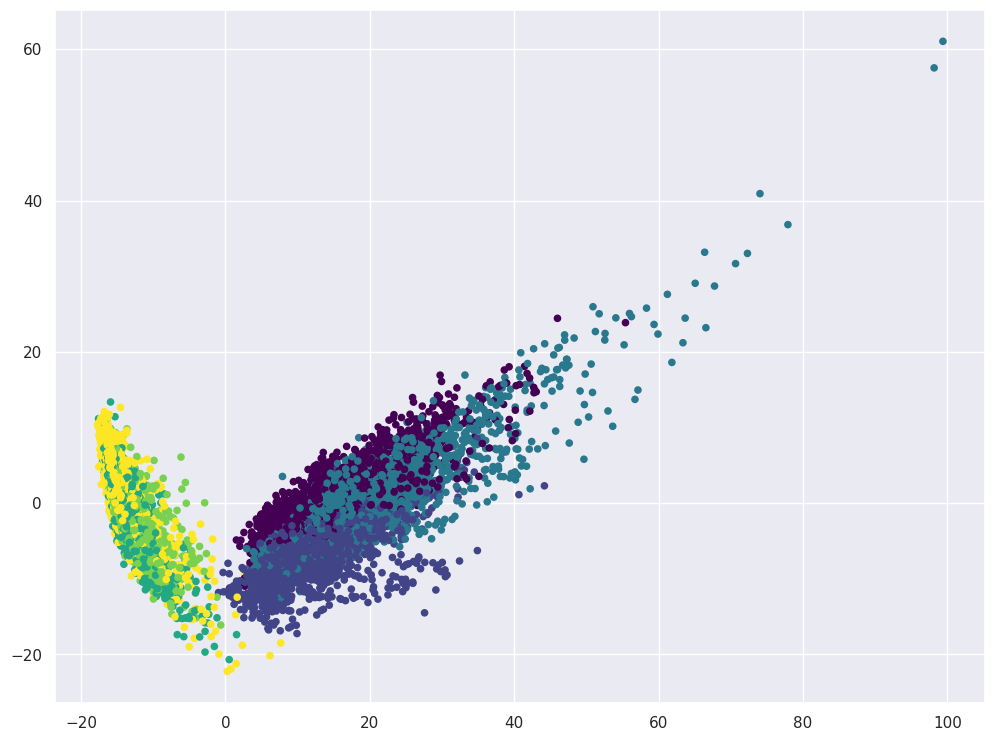

In [12]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

Вопрос 3 (0.5 балла)

Если все получилось правильно, вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?

Ответ: два кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание).

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [13]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

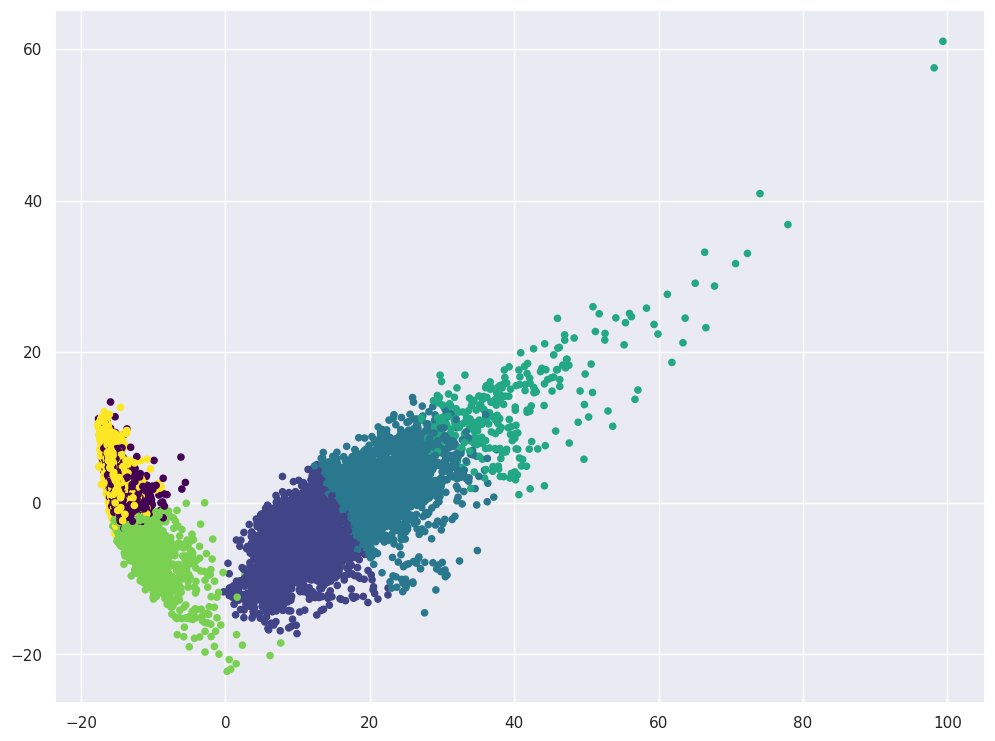

In [14]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [15]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Вопрос 4 (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой метрики из текста?

Варианты:
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Ответ: перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [16]:
inertia = []
for k in tqdm(range(1, n_classes + 1)):
    km = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    km.fit(X_pca)
    inertia.append(km.inertia_)

100%|██████████| 6/6 [01:14<00:00, 12.44s/it]


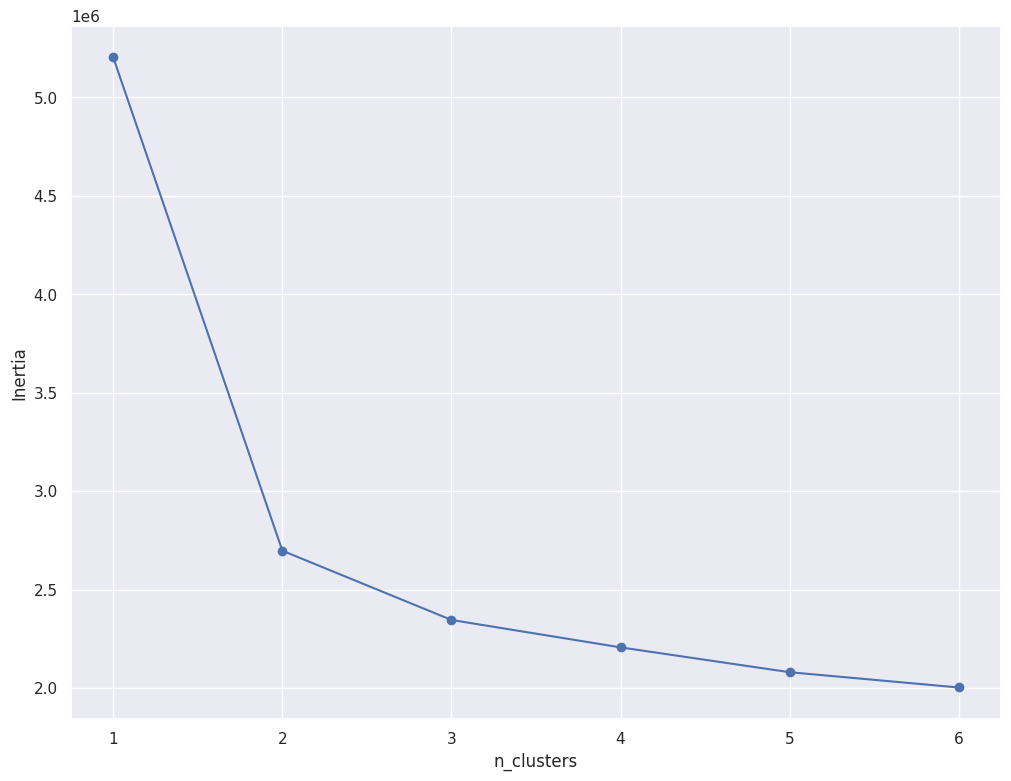

In [17]:
plt.plot(range(1, n_classes + 1), inertia, "-o")
plt.xlabel("n_clusters")
plt.ylabel("Inertia")
plt.xticks(range(1, n_classes + 1));

Вопрос 5 (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?

Варианты:
- 1
- 2
- 3
- 4

Ответ: 2

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [18]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [19]:
ari_kmeans = metrics.adjusted_rand_score(y, cluster_labels)
ari_ag = metrics.adjusted_rand_score(y, ag.labels_)
ari_kmeans, ari_ag

(0.4198070012602345, 0.49362763373004886)

Вопрос 6 (1 балл)

Отметьте все верные утверждения.

Варианты:
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

Ответ: все три утверждения верны

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [20]:
cls_scaler = StandardScaler()
X_train_scaled = cls_scaler.fit_transform(X_train)
X_test_scaled = cls_scaler.transform(X_test)

In [21]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [22]:
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
best_svc.fit(X_train_scaled, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LinearSVC(max...ndom_state=17)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.001, 0.01, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candidate parameter

In [23]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, np.float64(0.9379785010699506))

Вопрос 7 (0.5 балла)

Какое значение гиперпараметра C было выбрано лучшим по итогам кросс-валидации?

Варианты:
- 0.001
- 0.01
- 0.1
- 1
- 10

Ответ: 0.1

In [24]:
y_predicted = best_svc.predict(X_test_scaled)

In [25]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


Вопрос 8 (0.5 балла)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты?

Ответ: по точности — стояние, по полноте — сидение

Вопрос 9 (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.

Варианты:
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%

Ответ: 4%

In [26]:
pca_clf = PCA(n_components=pca.n_components_, random_state=RANDOM_STATE)
X_train_pca = pca_clf.fit_transform(X_train_scaled)
X_test_pca = pca_clf.transform(X_test_scaled)

In [27]:
svc_pca = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
svc_pca.fit(X_train_pca, y_train)
svc_pca.best_params_, svc_pca.best_score_

({'C': 0.1}, np.float64(0.899078093905861))

In [28]:
svc_pca.score(X_test_pca, y_test)

0.9212758737699356

In [29]:
best_svc.best_score_ - svc_pca.best_score_

np.float64(0.0389004071640896)

Вопрос 10 (1 балл)

Выберите все верные утверждения:

Варианты:
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

Ответ: подходят варианты 2 и 3

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

 0    5619
 1    4447
 3     124
 4      54
 2      53
-1       2
Name: count, dtype: int64

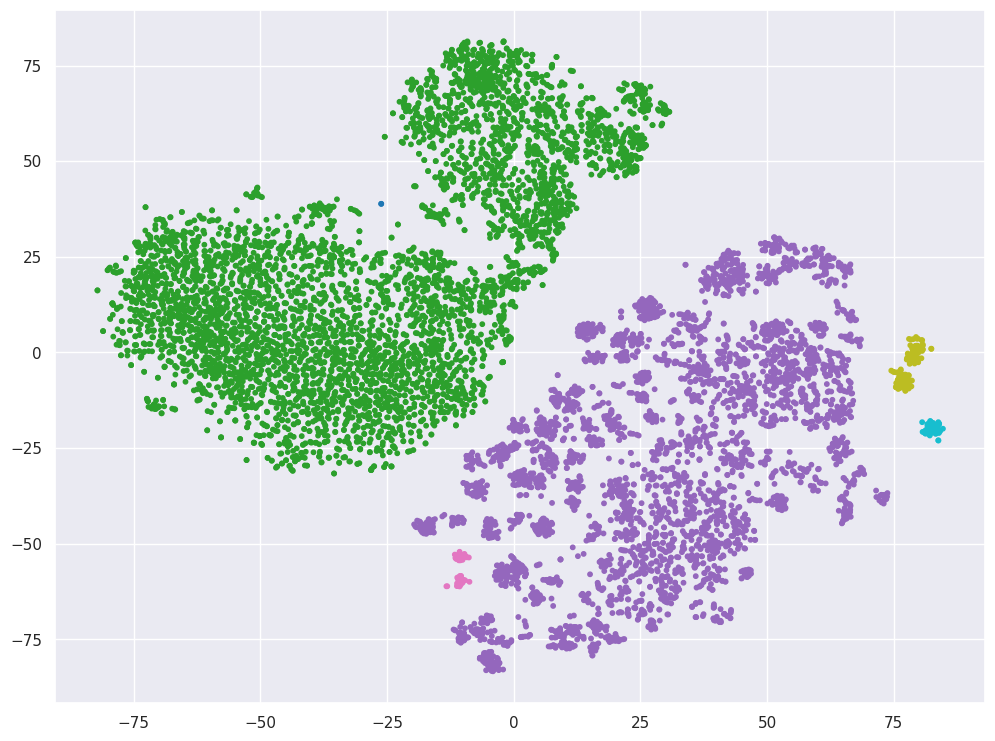

In [30]:
pca_tsne = PCA(n_components=50, random_state=RANDOM_STATE)
X_tsne_input = pca_tsne.fit_transform(X_scaled)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=40, learning_rate="auto", init="random")
X_tsne = tsne.fit_transform(X_tsne_input)
dbscan = DBSCAN(eps=5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_tsne)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap="tab10", s=10)
pd.Series(dbscan_labels).value_counts()